In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import warnings
from scipy.stats import ks_2samp, anderson_ksamp
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import re

In [2]:
predicted_rates_df = pd.read_csv('predicted_rates_sig_associations.tsv', sep = '\t', index_col = 0)
filtered_deg_df  = pd.read_csv('/Users/bamudamaris/Library/CloudStorage/GoogleDrive-fufordamaris@gmail.com/My Drive/Data/Datasets/deseqoutput_protein-ids.tsv', sep = '\t', index_col = 0).T

In [3]:
int_genes = set(['-'.join(g.split('-')[:-1]) for g in predicted_rates_df.columns])
int_deg = filtered_deg_df.loc[:, filtered_deg_df.columns.isin(int_genes)]
int_deg.head(3)

gene-id,cds-NP_414578.2,cds-NP_414677.1,cds-NP_414683.1,cds-NP_414706.2,cds-NP_414752.1,cds-NP_414760.1,cds-NP_414761.1,cds-NP_414767.1,cds-NP_414768.1,cds-NP_414776.1,...,cds-NP_418723.1,cds-NP_418724.1,cds-NP_418725.4,cds-NP_418726.1,cds-NP_418727.1,cds-NP_418733.1,cds-NP_418734.1,cds-NP_418735.2,cds-NP_418736.3,cds-NP_418740.1
NT12189,0.362177,1.230408,-1.030290,0.672323,-0.443725,0.776436,1.298233,0.539357,0.071231,1.368819,...,-6.801205,-5.341317,-5.301443,-4.398850,-4.910014,-6.313384,-8.486121,-8.306573,-8.132702,-6.892865
NT12177,2.176615,-7.427777,-1.003958,0.574438,-1.212497,-4.803334,-5.242669,-0.210362,0.313198,1.467764,...,-6.585919,-7.214152,-6.349599,-6.745688,-5.606532,1.165615,-6.033914,-2.345652,-2.845027,-0.440900
NT12130,1.569678,-6.937423,1.079472,1.579887,0.269665,-1.889564,-1.424491,0.958389,1.154479,0.753323,...,-8.309324,-6.881677,-5.802867,-6.548193,-6.518633,1.688403,-2.777924,-1.683232,-1.386437,0.036088


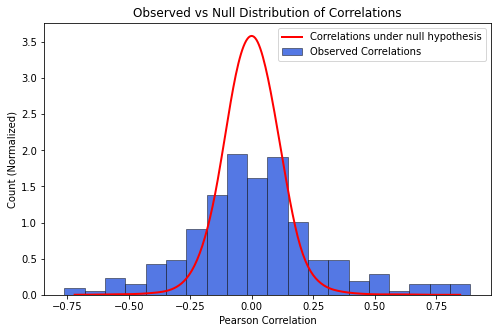

In [4]:
import re
def standardize_gene_names(gene_name):
    return re.sub(r"-\d+$", "", gene_name)

# standardize column names in predicted_rates_df
predicted_rates_df.columns = [standardize_gene_names(col) for col in predicted_rates_df.columns]

# align strains in both datasets
common_strains = predicted_rates_df.index.intersection(filtered_deg_df.index)
predicted_rates_df = predicted_rates_df.loc[common_strains]
filtered_deg_df = filtered_deg_df.loc[common_strains]

# aggregate predicted values by mean for duplicate gene names (likely due to different associated kmers for a single gene)
predicted_rates_df = predicted_rates_df.groupby(predicted_rates_df.columns, axis=1).mean()
common_genes = predicted_rates_df.columns.intersection(filtered_deg_df.columns)

#compute correlations
pearson = {}
observed_corrs = []
all_permuted_corrs = []

for gene in common_genes:
    df_merged = pd.merge(
        predicted_rates_df[[gene]], filtered_deg_df[[gene]],
        left_index=True, right_index=True, how='inner'
    ).dropna()
    
    df_merged.columns = ['Predicted transcription rate', 'log2foldchange'] 
    if df_merged['Predicted transcription rate'].nunique() == 1 or df_merged['log2foldchange'].nunique() == 1:
        continue  # Skip if constant values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p, _ = sp.pearsonr(df_merged['Predicted transcription rate'], df_merged['log2foldchange'])

    pearson[gene] = round(p, 2)
    observed_corrs.append(p)

# Use permutation test to simulate data for null distribution
def permutation_test(actual, predicted, n_permutations=1000):
    mask = np.isfinite(actual) & np.isfinite(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    observed_corr, _ = sp.pearsonr(actual, predicted)
    
    permuted_corrs = np.array([
        sp.pearsonr(actual, np.random.permutation(predicted))[0]
        for _ in range(n_permutations)
    ])
    
    return observed_corr, permuted_corrs

for gene in common_genes:
    if gene not in pearson:
        continue
    observed_corr, permuted_corrs = permutation_test(
        filtered_deg_df[gene], predicted_rates_df[gene]
    )
    all_permuted_corrs.extend(permuted_corrs)
    

# create plots
bins = np.histogram_bin_edges(observed_corrs, bins=20)

# compute normalized histograms
observed_hist, _ = np.histogram(observed_corrs, bins=bins, density=True)
null_hist, _ = np.histogram(all_permuted_corrs, bins=bins, density=True)

# Compute bin centers for line plot
bin_centers = (bins[:-1] + bins[1:]) / 2


num_smooth_points = 300  # Increase resolution for smoother line
bin_centers_smooth = np.linspace(bin_centers.min(), bin_centers.max(), num_smooth_points)


spline = make_interp_spline(bin_centers, null_hist, k=3)  # k=3 for cubic spline
null_hist_smooth = spline(bin_centers_smooth)


plt.figure(figsize=(8, 5))

# plot observed correlations as smoothed histogram bars
plt.bar(
    bin_centers, observed_hist, width=np.diff(bins), 
    color='royalblue', alpha = 0.9, edgecolor='black', linewidth=0.5, label='Observed Correlations'
)

# plot smoothed null distribution as a spline curve
plt.plot(bin_centers_smooth, null_hist_smooth, color='red', linewidth=2, label='Correlations under null hypothesis')

# # overlay mean observed correlation line
# plt.axvline(np.mean(observed_corrs), color='black', linestyle='dashed', label="Mean Observed Correlation")

# Labels and legend
plt.xlabel('Pearson Correlation')
plt.ylabel('Count (Normalized)')
plt.legend()
plt.title('Observed vs Null Distribution of Correlations')

# Show plot
#plt.savefig('corr_distribution.svg', dpi = 300)
plt.show()


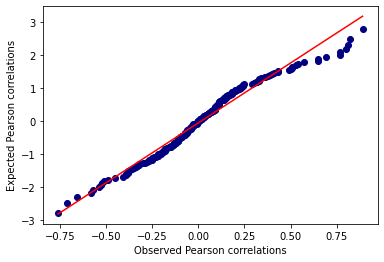

In [7]:
def qq_plot_pearson_swapped(pearson_dict):
    """Generates a Q-Q plot from Pearson correlation values with swapped axes, ensuring a correct reference line."""
    
    # Extract Pearson correlation coefficients as a list
    correlation_values = list(pearson_dict.values())

    # Compute theoretical and observed quantiles
    res = sp.probplot(correlation_values, dist="norm")

    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Scatter plot with swapped axes
    ax.scatter(res[0][1], res[0][0], color='navy')

    # Corrected reference line calculation
    slope, intercept = np.polyfit(res[0][1], res[0][0], 1)  # Fit line with swapped axes
    ax.plot(res[0][1], slope * res[0][1] + intercept, color='red')

    # Set labels with swapped axes
    ax.set_xlabel('Observed Pearson correlations')  
    ax.set_ylabel('Expected Pearson correlations')  

qq_plot_pearson_swapped(pearson)
plt.savefig('corr_distribution2.svg', dpi = 300)

/var/folders/ys/t0s5987940jf4x94c3v464w00000gn/T/ipykernel_8644/1765506556.py:73: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat, ad_critical, ad_significance = anderson_ksamp([observed_corrs, all_permuted_corrs])



=== Kolmogorov-Smirnov (KS) Test ===
KS Test Statistic: 0.1571
KS Test p-value: 0.0000
The observed and null distributions are significantly different (p < 0.05).

=== Anderson-Darling (AD) Test ===
AD Test Statistic: 53.8093
Significance Level (p-value equivalent): 0.0010
The observed and null distributions are significantly different (p < 0.05).


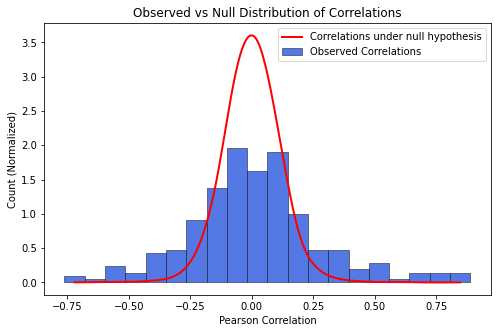


=== Permutation Test Results ===
Number of significant genes (p < 0.05): 51
Example significant genes: ['cds-NP_414683.1', 'cds-NP_414752.1', 'cds-NP_414784.1', 'cds-NP_414847.3', 'cds-NP_414858.1'] (showing up to 5)


In [5]:

# Standardize gene names function
def standardize_gene_names(gene_name):
    return re.sub(r"-\d+$", "", gene_name)

# Standardize column names in predicted_rates_df
predicted_rates_df.columns = [standardize_gene_names(col) for col in predicted_rates_df.columns]

# Align strains in both datasets
common_strains = predicted_rates_df.index.intersection(filtered_deg_df.index)
predicted_rates_df = predicted_rates_df.loc[common_strains]
filtered_deg_df = filtered_deg_df.loc[common_strains]

# Aggregate predicted values by mean for duplicate gene names
predicted_rates_df = predicted_rates_df.groupby(predicted_rates_df.columns, axis=1).mean()
common_genes = predicted_rates_df.columns.intersection(filtered_deg_df.columns)

# Compute observed correlations
pearson = {}
observed_corrs = []
all_permuted_corrs = []

for gene in common_genes:
    df_merged = pd.merge(
        predicted_rates_df[[gene]], filtered_deg_df[[gene]],
        left_index=True, right_index=True, how='inner'
    ).dropna()
    
    df_merged.columns = ['Predicted transcription rate', 'log2foldchange'] 
    if df_merged['Predicted transcription rate'].nunique() == 1 or df_merged['log2foldchange'].nunique() == 1:
        continue  # Skip if constant values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p, _ = sp.pearsonr(df_merged['Predicted transcription rate'], df_merged['log2foldchange'])

    pearson[gene] = round(p, 2)
    observed_corrs.append(p)

# Permutation test function
def permutation_test(actual, predicted, n_permutations=1000):
    mask = np.isfinite(actual) & np.isfinite(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    observed_corr, _ = sp.pearsonr(actual, predicted)
    
    permuted_corrs = np.array([
        sp.pearsonr(actual, np.random.permutation(predicted))[0]
        for _ in range(n_permutations)
    ])
    
    return observed_corr, permuted_corrs

# Compute permutation correlations and p-values for each gene
gene_p_values = {}

for gene in common_genes:
    if gene not in pearson:
        continue
    observed_corr, permuted_corrs = permutation_test(
        filtered_deg_df[gene], predicted_rates_df[gene]
    )
    all_permuted_corrs.extend(permuted_corrs)

    # Compute empirical p-value for this gene
    p_value = np.mean(permuted_corrs >= observed_corr)
    gene_p_values[gene] = p_value

# KS-test between observed and permuted correlation distributions
ks_stat, ks_p_value = ks_2samp(observed_corrs, all_permuted_corrs)

# Anderson-Darling test between observed and permuted distributions
ad_stat, ad_critical, ad_significance = anderson_ksamp([observed_corrs, all_permuted_corrs])

# Print KS-test results
print(f"\n=== Kolmogorov-Smirnov (KS) Test ===")
print(f"KS Test Statistic: {ks_stat:.4f}")
print(f"KS Test p-value: {ks_p_value:.4f}")

if ks_p_value < 0.05:
    print("The observed and null distributions are significantly different (p < 0.05).")
else:
    print("The observed and null distributions are NOT significantly different (p > 0.05).")

# Print AD-test results
print("\n=== Anderson-Darling (AD) Test ===")
print(f"AD Test Statistic: {ad_stat:.4f}")
print(f"Significance Level (p-value equivalent): {ad_significance:.4f}")

if ad_significance < 0.05:
    print("The observed and null distributions are significantly different (p < 0.05).")
else:
    print("The observed and null distributions are NOT significantly different (p > 0.05).")

# Create plots
bins = np.histogram_bin_edges(observed_corrs, bins=20)

# Compute normalized histograms
observed_hist, _ = np.histogram(observed_corrs, bins=bins, density=True)
null_hist, _ = np.histogram(all_permuted_corrs, bins=bins, density=True)

# Compute bin centers for line plot
bin_centers = (bins[:-1] + bins[1:]) / 2
num_smooth_points = 300  
bin_centers_smooth = np.linspace(bin_centers.min(), bin_centers.max(), num_smooth_points)

spline = make_interp_spline(bin_centers, null_hist, k=3)
null_hist_smooth = spline(bin_centers_smooth)

plt.figure(figsize=(8, 5))

# Plot observed correlations as histogram bars
plt.bar(
    bin_centers, observed_hist, width=np.diff(bins), 
    color='royalblue', alpha=0.9, edgecolor='black', linewidth=0.5, label='Observed Correlations'
)

# Plot smoothed null distribution as a spline curve
plt.plot(bin_centers_smooth, null_hist_smooth, color='red', linewidth=2, label='Correlations under null hypothesis')

# Labels and legend
plt.xlabel('Pearson Correlation')
plt.ylabel('Count (Normalized)')
plt.legend()
plt.title('Observed vs Null Distribution of Correlations')

# Save and show the plot
#plt.savefig('corr_distribution.svg', dpi=300)
plt.show()

# Print summary of permutation test results
significant_genes = {gene: p for gene, p in gene_p_values.items() if p < 0.05}
print(f"\n=== Permutation Test Results ===")
print(f"Number of significant genes (p < 0.05): {len(significant_genes)}")
print(f"Example significant genes: {list(significant_genes.keys())[:5]} (showing up to 5)")


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load genome-wide correlation values (asso_correlation) as null distribution
# Example assumes you already loaded association_df from your TSV file
null_corrs = pearson

# Load observed promoter-gene correlation values
# Example assumes you already calculated observed_corrs (list or array of Pearson r)
observed_corrs_array = np.array(observed_corrs)

# Sort for Q-Q plot
observed_sorted = np.sort(observed_corrs_array)
null_sorted = np.sort(null_corrs)

# Match lengths
min_len = min(len(observed_sorted), len(null_sorted))
observed_sorted = observed_sorted[:min_len]
null_sorted = null_sorted[:min_len]

# Create Q-Q plot
plt.figure(figsize=(7, 7))
plt.plot(null_sorted, observed_sorted, 'o', color='darkgreen', alpha=0.7, markersize=5, label='Observed vs Genome-wide Null')
plt.plot([null_sorted.min(), null_sorted.max()], [null_sorted.min(), null_sorted.max()], 'r--', label='y = x (null expectation)')

plt.xlabel('Quantiles of Genome-wide Pearson Correlations', fontsize=12)
plt.ylabel('Quantiles of Observed Correlations (Promoter Variants)', fontsize=12)
plt.title('Q-Q Plot: Observed vs Genome-wide Null Correlation Values', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


AxisError: axis -1 is out of bounds for array of dimension 0

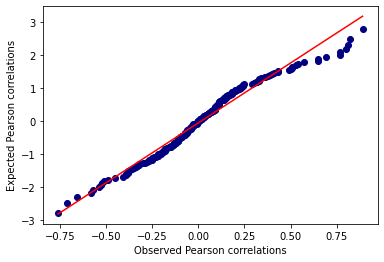

In [10]:
def qq_plot_pearson_swapped(pearson_dict):
    """Generates a Q-Q plot from Pearson correlation."""
    
    # Extract Pearson correlation coefficients as a list
    correlation_values = list(pearson_dict.values())

    # Compute theoretical and observed quantiles
    res = sp.probplot(correlation_values, dist="norm")

    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Scatter plot with swapped axes
    ax.scatter(res[0][1], res[0][0], color='navy')

    # Corrected reference line calculation
    slope, intercept = np.polyfit(res[0][1], res[0][0], 1)  # Fit line with swapped axes
    ax.plot(res[0][1], slope * res[0][1] + intercept, color='red')

    # Set labels with swapped axes
    ax.set_xlabel('Observed Pearson correlations')  
    ax.set_ylabel('Expected Pearson correlations')  

qq_plot_pearson_swapped(pearson)
#plt.savefig('corr_distribution2.svg', dpi = 300)

In [ ]:
#the qq plots should use your observed correlation values, the expected correlation values should come from the permuted values and not this one. 